<h1 align="center">Reorganizing the NFL</h1>
<h3 align="center">By Vade Kemensita-Hale and Steven Wood</h3>

## The Problem

In the NFL, teams must play the others in their division twice a year. Divisions are labeled “North”, “South”, “East”, and “West”, but teams are seemingly haphazardly organized. The cardinal directionally named divisions are a very broad generalization of team locations. For example in the AFC “East”, why are the New England Patriots in the same division as the Miami Dolphins, forcing them both to trek the entire eastern seaboard twice a year? 

These divisional groupings are vestiges of an ever evolving league. The additions and relocations of teams over the last 60 years has driven divisional groupings instead of using an optimal solution. Unnecessary travel time should be minimized as it’s taxing to players and the environment. This project’s purpose is to propose new divisional and conference groupings to minimize the travel time wasted in a season.

## Our Approach

In [3]:
%load_ext gams_magic

In [4]:
%gams_cleanup -k
%gams_reset

In [5]:
%%gams
set div /1*8/,
    teams;

$ call csv2gdx Coordinates.csv useHeader=y id=teams index=1
$gdxIn Coordinates.gdx
$load teams = teams
$gdxIn

parameter dist(teams, teams)
/
$ondelim
$include distances.csv
$offdelim
/;

alias(teams,teams2);
binary variable x(teams, teams2, div);
free variable totalDist;

equations
    matchups(teams,teams),
    games(teams),
    matchupReflex(teams,teams2,div),
    balanceDiv(div),
    sameDiv(teams,div),
    defObj
;

matchups(teams,teams2)..
    sum(div, x(teams,teams2,div)) =L= 1;
    
games(teams)..
    4 =E= sum((teams2,div), x(teams,teams2,div));
    
matchupReflex(teams,teams2,div)..
    x(teams,teams2,div) =E= x(teams2,teams,div);

balanceDiv(div)..
    sum((teams,teams2), x(teams,teams2,div)) =E= 16;
    
sameDiv(teams,div)..
    sum(teams2, x(teams,teams2,div)) =E= 4*x(teams,teams,div);
    
defObj..
    totalDist =E= sum((teams, teams2, div), 2*x(teams, teams2, div)*dist(teams,teams2));
    
model NflReorg /all/;

solve NflReorg using mip min totalDist;

options x:0:0:1;
display x.l;

parameter y(teams,div);

loop((teams,div) $ (x.l(teams,teams,div) > 0),
    y(teams,div) = 1;

);
display y;


,Solver Status,Model Status,Objective,#equ,#var,Model Type,Solver,Solver Time
0,Normal (1),Integer (8),70569.3535,9257,8193,MIP,CPLEX,172.868


In [6]:
%gams_pull -d y
display(y)

,teams,div,value
0,Titans,7,1
1,Giants,1,1
2,Steelers,3,1
3,Panthers,7,1
4,Ravens,3,1
5,Buccaneers,6,1
6,Colts,7,1
7,Vikings,4,1
8,Cardinals,8,1
9,Cowboys,2,1


In [64]:
import geopandas
import matplotlib.pyplot as plt
import csv
%matplotlib inline

colors = ['', 'red', 'orange', 'yellow', 'green', 'blue', 'indigo', 'violet', 'black']

def findCityColor(team):
    for row in y.iterrows():
        if row[1][0] == team:
            return colors[int(row[1][1])]
    return 0

# load the world map and extract the map of United States of America
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
us = world[(world.pop_est>0) & (world.name=="United States of America")]
city = dict()
with open('Coordinates.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=',')
        line_count = 0
        for row in csv_reader:
            if line_count == 0:
                line_count += 1
            else:
                city[row[0]] = [ float(row[3]), float(row[2])]
                line_count += 1



    
    
def plot_division_layout():
    us.plot(figsize=(20,20),color='white', edgecolor='black')
    for k, v in city.items():
        plt.scatter(*v, c=findCityColor(k),alpha=0.5)
        plt.text(*v, k)
    plt.xlim(-130,-60)
    plt.ylim(23,53)

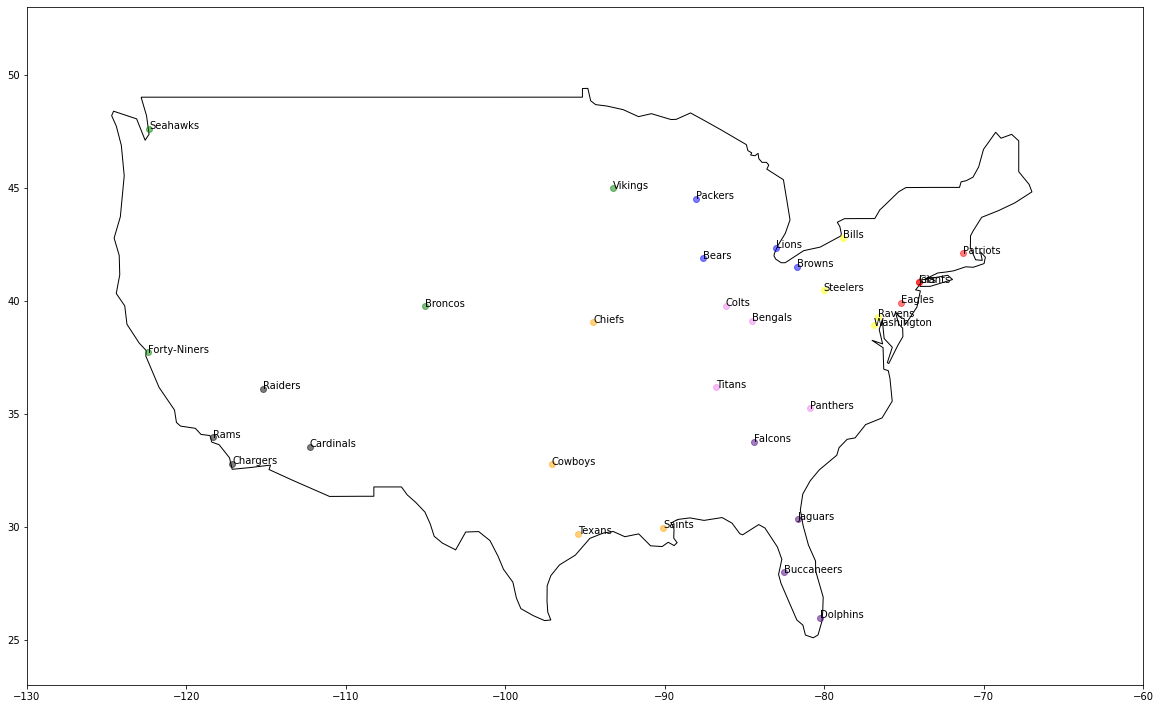

In [65]:
plot_division_layout()